# Ensemble Study

In this notebook we study the features of annotated hypergraphs in reference to an ensemble of hypergraphs generated from a null model.

In [1]:
# !pip install seaborn --user --quiet

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
def read_results(path):
    """Read results from a directory."""
    
    original = pd.read_csv(f'{path}/original.csv', index_col=0, header=None)[1]
    role_preserving_ensemble = pd.read_csv(f'{path}/role_preserving_ensemble.csv', index_col=False, header=0)
    role_destroying_ensemble = pd.read_csv(f'{path}/role_destroying_ensemble.csv', index_col=False, header=0)

    return original, role_preserving_ensemble, role_destroying_ensemble

In [3]:
original, preserving_ensemble, destroying_ensemble = read_results('../results/enron_r/')
results = read_results('../results/enron_r')

In [4]:
def get_min_max(a, b):
    """Get bounds for two series"""

    lower = min(a.min(), b.min())
    upper = max(a.max(), b.max())
    
    return lower, upper
    
def plot_feature(feature, original, role_preserving_ensemble, role_destroying_ensemble, num_bins=20, **fig_kwargs):
    """Plot a feature"""
    
    fig = plt.figure(**fig_kwargs)
    ax = fig.add_subplot(111)

    ymax=0
    
#     lower, upper = get_min_max(role_preserving_ensemble[feature],role_destroying_ensemble[feature])
#     bins = np.linspace(lower, upper, num_bins)
    
    lower, upper = get_min_max(role_preserving_ensemble[feature],role_preserving_ensemble[feature])
    bins = np.linspace(lower, upper, num_bins)
    y,binEdges=np.histogram(role_preserving_ensemble[feature], bins=bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    rp = ax.plot(bincenters,y,'-o', color='r', label='Role Preserving Ensemble')
    
    ymax=max(ymax,max(y))
    
    lower, upper = get_min_max(role_destroying_ensemble[feature],role_destroying_ensemble[feature])
    bins = np.linspace(lower, upper, num_bins)
    y,binEdges=np.histogram(role_destroying_ensemble[feature], bins=bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    rd = ax.plot(bincenters,y,'-o', color='b', label='Role Destroying Ensemble')
    
    ymax=max(ymax,max(y))
        
    line = ax.vlines(original[feature],0.0,ymax, label='Data')
    
    ax.legend(loc='best')
    
    return fig, ax, (line, rp, rd)

In [94]:
def get_features_for_dataset(dataset, features):
    """
    """
    original, preserving_ensemble, destroying_ensemble = read_results(f'../results/{dataset}/')
    
    all_features = []
    for feature in features:

        rp = preserving_ensemble[feature]
        rd = destroying_ensemble[feature]
        og = pd.Series(original[feature])
        combined = pd.DataFrame(pd.concat([rp,rd,og], axis=0))
        combined.columns = [feature]
        all_features.append(combined)
    
    combined = pd.concat(all_features, axis=1)
    combined['model'] = pd.Series(data=(['RP']*len(rp) + ['RD']*len(rd) + ['OG']), index=combined.index)
    return combined

def get_datasets_for_feature(feature, datasets):
    """
    """
    if isinstance(feature,str):
        feature = [feature]
    
    
    all_data = []
    
    for feature in feature:
        for data in datasets:
    #         original, preserving_ensemble, destroying_ensemble = read_results(f'../results/{data}/')
    #         rp = preserving_ensemble[feature].head(500) # ANDY QUICK FIX
    #         rd = destroying_ensemble[feature].head(500) # ANDY QUICK FIX
    #         og = pd.Series(original[feature])
    #         combined = pd.DataFrame(pd.concat([rp,rd,og], axis=0))
    #         combined.columns = [data]

            original, preserving_ensemble, destroying_ensemble = read_results(f'../results/{data}/')
            rp = preserving_ensemble[feature].head(500) # ANDY QUICK FIX
            rd = destroying_ensemble[feature].head(500) # ANDY QUICK FIX
            og = pd.Series(original[feature])
            og = pd.DataFrame(og).T

            combined = pd.concat([og,rp,rd],
                             keys=['Original','Role-preserving','Non-role-preserving'], 
                             names=['ensemble','sample'])

            combined = combined.stack()
            combined.index.names = ['ensemble','sample','feature']
            combined = combined.reset_index()
            combined = combined.rename({0:'value'}, axis=1)
            combined['data'] = data
            combined['feature'] = feature

            all_data.append(combined)

    combined = pd.concat(all_data, axis=0)
#     combined['model'] = pd.Series(data=(['RP']*len(rp) + ['RD']*len(rd) + ['OG']), index=combined.index)
    return combined   

In [99]:
combined = get_datasets_for_feature(feature='neighbourhood_role_entropy',
                                    datasets=['enron_r','stack_overflow_r','math_overflow_r', 
                                              'scopus_multilayer_r','movielens_r', 'twitter_r'])

#### Figure 3

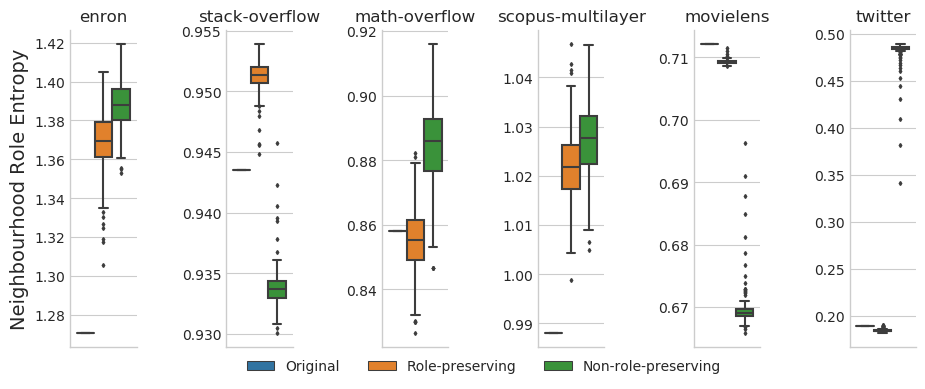

In [106]:
with plt.style.context("seaborn-whitegrid", {'font.size':14}):

    fontsize=14
    
    sax = sns.catplot(data=combined,
                        kind='box',
                        hue='ensemble',
                        y='value',
                        x='feature',
                        col='data',
                        fliersize=2,
                        linewidth=1.5,
                        notch=False,
                        legend=False,
                        sharey=False,
                        legend_out=True,
                        height=4, 
                        aspect=0.4,  
                        );
    
    fig = plt.gcf()
    
    for ix, ax in enumerate(fig.axes):
        
        ax.set_xlabel(None);
        ax.set_xticklabels([None]);
        
        ax.set_title(ax.title.get_text().split('=')[-1].strip().strip('r').strip('_').replace('_','-'))
        
        if ix==0:
            ax.set_ylabel('Neighbourhood Role Entropy', fontsize=fontsize);
            ax.legend(ncol=3, bbox_to_anchor=(10,0))
    
    fig.savefig('../fig/ensemble_local_role_entropy.pdf', bbox_inches='tight')

#### Figure 4

In [108]:
combined = get_datasets_for_feature(feature=['neighbourhood_role_entropy', 'weighted_degree_entropy',
                                            'weighted_pagerank_entropy', 'node_role_entropy', 'connected_components',
                                             'weighted_eigenvector_entropy'],
                                    datasets=['enron_r','stack_overflow_r','math_overflow_r', 
                                              'scopus_multilayer_r','movielens_r', 'twitter_r'])

/home/mellor/anaconda3/envs/ahyper/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


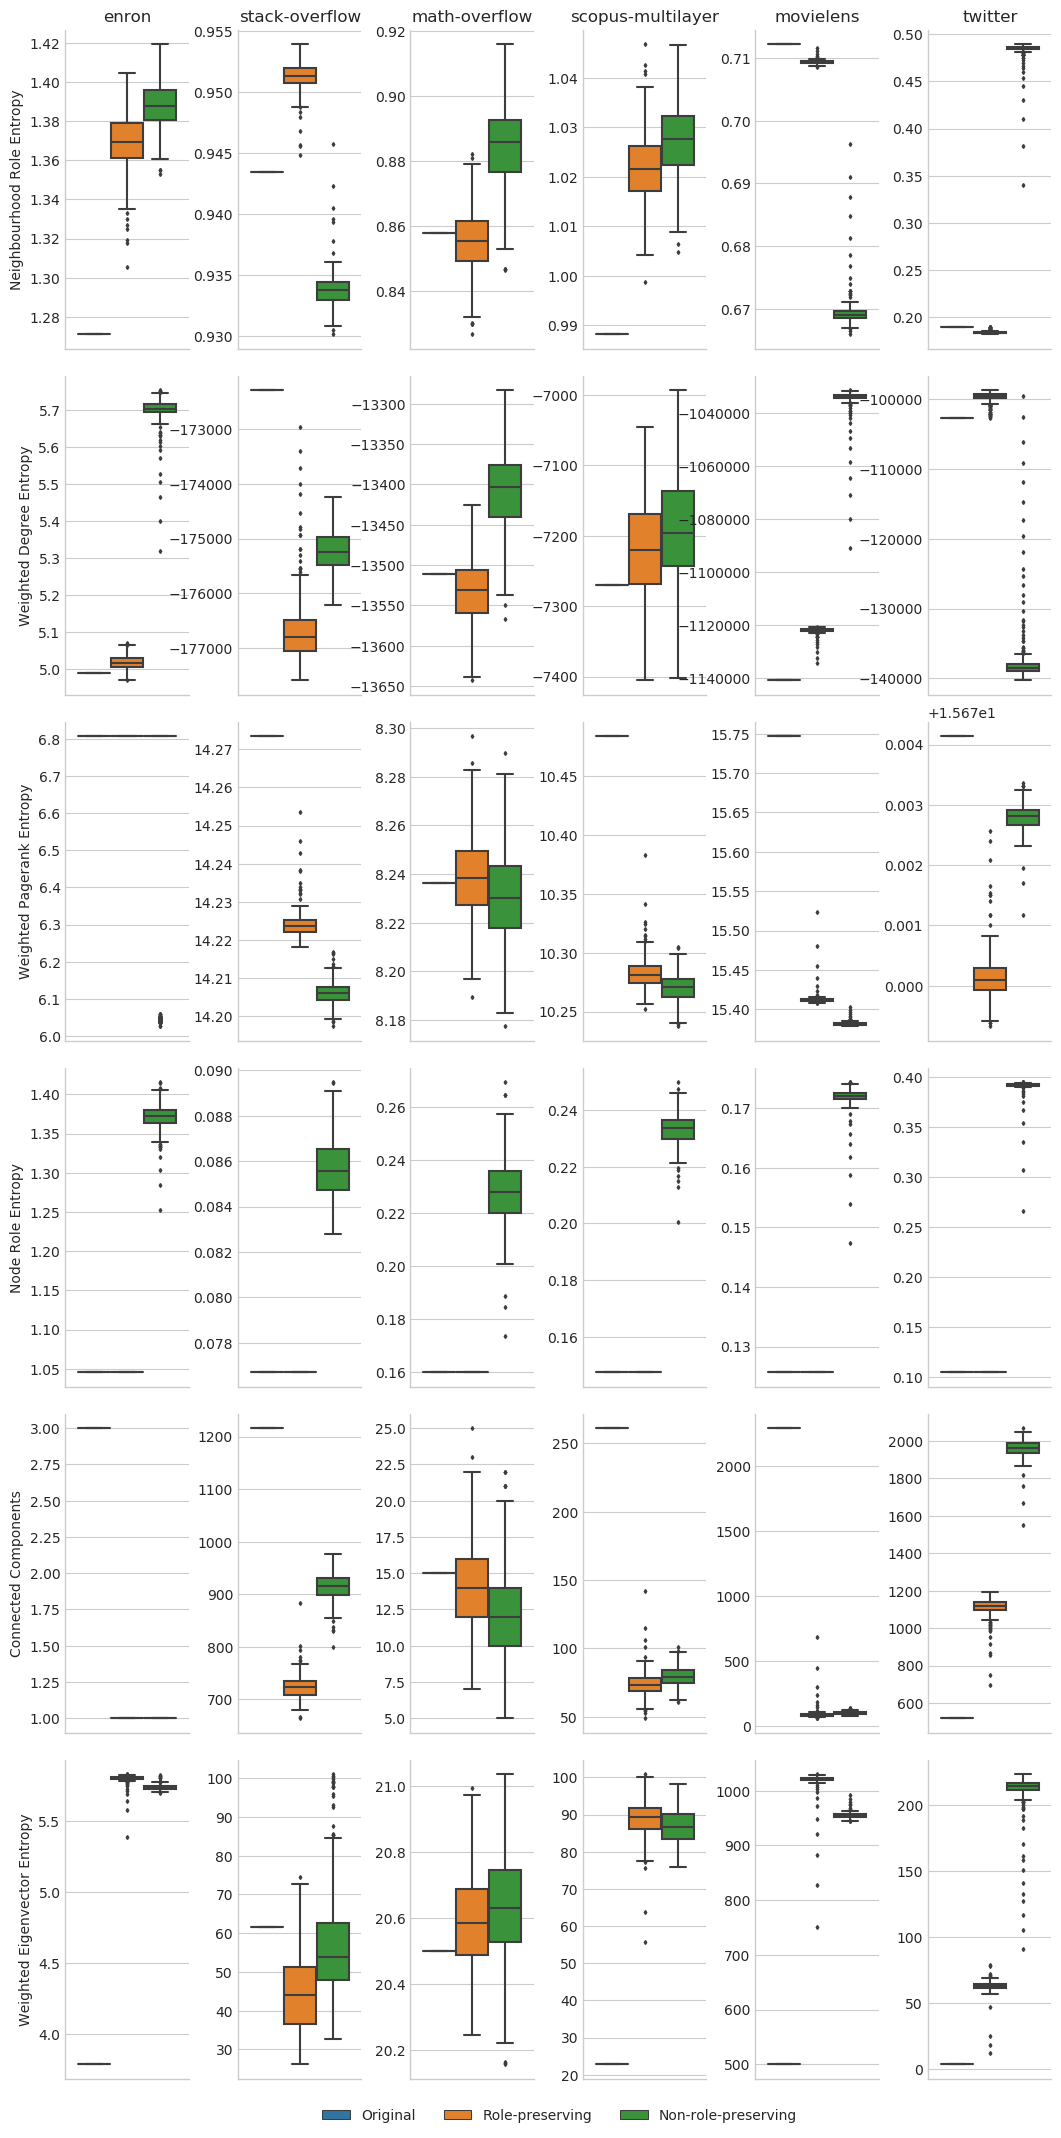

In [140]:
with plt.style.context("seaborn-whitegrid", {'font.size':14}):

    fontsize=14
    
    sax = sns.catplot(data=combined,
                        kind='box',
                        hue='ensemble',
                        y='value',
                        x='x',
                        col='data',
                        row='feature',
                        fliersize=2,
                        linewidth=1.5,
                        notch=False,
                        legend=False,
                        sharey=False,
                        legend_out=True,
                        height=3.5, 
                        aspect=0.5,  
                        );
    
    n_features = combined.feature.nunique()
    
    fig = plt.gcf()
    
    for ix, ax in enumerate(fig.axes):

        ax.set_xlabel(None);
        ax.set_xticklabels([None]);
        
        long_title = ax.get_title()
        feature = long_title.split('|')[0].split('=')[-1].strip().replace('_', ' ').title()
        dataset = long_title.split('|')[-1].split('=')[-1].strip().replace('_', '-').strip('r').strip('-')
        
        if (ix % n_features) == 0:
            ax.set_ylabel(feature)
        
        if ix < n_features:
            ax.set_title(dataset)
        else:
            ax.set_title(None)

        if ix==0:
            ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(4,-5.6))
            
    fig.savefig('../fig/ensemble_all_features.pdf', bbox_inches='tight')

### Tables

In [219]:
def get_statistics(feature, original, role_preserving_ensemble, role_destroying_ensemble):
    """Get the statistics for a specific feature of a specific dataset. """
    
    data = original[feature]
    pres = role_preserving_ensemble[feature]
    pres_mean, pres_std = pres.mean(), pres.std()
    
    if np.isclose(pres_std,0.0):
        pres_z = 0
    else:
        pres_z = (data - pres_mean)/pres_std # Not using abs to detect under or over rep.
    
    dest = role_destroying_ensemble[feature]
    dest_mean, dest_std = dest.mean(), dest.std()
    if np.isclose(dest_std,0.0):
        dest_z = 0
    else:
        dest_z = (data - dest_mean)/dest_std

    return pd.DataFrame({'Role Preserving Ensemble': {'data':data, 'mean':pres_mean, 'std':pres_std, 'z':pres_z},
                         'Role Destroying Ensemble': {'data':data, 'mean':dest_mean, 'std':dest_std, 'z':dest_z}})

def statistics_table(data_list, feature_list=None):
    """Returns a complete statistical summary of the data analysis."""
    
    # Currently needs generalising if it goes into the main package.

    
    data_tables = []
    for dataset in data_list:
        
        results = read_results(f'../results/{dataset}')
        feature_tables = []
        if feature_list is None: feature_list = results[0].index
        
        for feature in feature_list:
            feature_tables.append(get_statistics(feature, *results))
        feature_table = pd.concat(feature_tables, keys=feature_list, names=['feature'])
        data_tables.append(feature_table)
    complete_table = pd.concat(data_tables, keys=data_list, names=['data'])   
    
    return complete_table

In [220]:
DATASETS = ['enron', 'enron_r', 
          'math_overflow', 'math_overflow_r', 
          'scopus_multilayer', 'scopus_multilayer_r',
          'stack_overflow', 'stack_overflow_r',
          'movielens', 'movielens_r',
          'twitter', 'twitter_r'
           ]

stats = statistics_table(DATASETS)

def color_significance(val):
    """
    Color values which are statistically significant.
    """
    if val > 2:
        color='red'
    elif val < -2:
        color='blue'
    else:
        color='black'
    return 'color: %s' % color

In [221]:
stats.xs('z', level=2).style.applymap(color_significance)

In [301]:
def format_and_color(x, color=True):
    """ Converts to 2 d.p. and colours red if greater than two sigma, blue less than two sigma. """
    number = '{:.2f}'.format(x)
    if color:
        if x > 2:
            return r'\textcolor{red}{%s}' % number
        elif x < -2:
            return r'\textcolor{blue}{%s}' % number
        else:
            return number
    else:
        return number 

def produce_latex_table(statistics, datasets, feature_map=None, data_map=None, as_tex=True):
    """
    Produce the table in Latex format to be used in the manuscript.
    """
    
    if feature_map is None:
        pass
    
    comb = pd.concat([statistics.xs('mean', level=2), statistics.xs('z', level=2)], axis=1, names=['mean', 'z'])
    comb.columns = pd.MultiIndex(levels=[['rp', 'rd'], ['mean', 'z']], codes=[[0,1,0,1], [0,0,1,1]])
    
    comb = comb.loc[datasets,:].reset_index(drop=False)
    
    
    if feature_map is not None:
        comb['feature'] = comb.feature.apply(lambda x: feature_map[x])
    if data_map is not None:
        comb['data'] = comb.data.apply(lambda x: data_map[x])
        
    comb = comb.set_index(['data','feature'])
    
    # Construct the original dataframe.
    originals = []
    for data in datasets:
        original, _, _ = read_results(f'../results/{data}/')
        original = pd.DataFrame(original)
        original['data'] = data
        originals.append(original)

    originals = pd.concat(originals)
    originals = originals.reset_index(drop=False)
    originals.columns = ['feature','original','data']
    originals = originals.set_index(['data','feature'])
    originals.columns = pd.MultiIndex(levels=[[''],['original']], codes=[[0],[0]])
    
    comb = pd.merge(left=originals, right=comb, left_index=True, right_index=True).sort_index().sort_index(axis=1)
    
    if as_tex:
        return comb.to_latex(formatters={('rp','z'): lambda x: format_and_color(x),
                                       ('rd','z'): lambda x: format_and_color(x),                                                                           
                                       ('rp','mean'): lambda x: '{:0.2f}'.format(x),
                                       ('rd','mean'): lambda x: '{:0.2f}'.format(x),
                                        ('','original'): lambda x: '{:0.2f}'.format(x)},
                           escape=False)
    return comb.style.applymap(color_significance, subset=[('rp','z'),('rd','z')])

In [302]:
produce_latex_table(stats, datasets=['enron_r', 'stack_overflow_r'], as_tex=False)

In [303]:
print(produce_latex_table(stats, datasets=['enron_r', 'stack_overflow_r']))

\begin{tabular}{llrrrrr}
\toprule
                 &                           & \multicolumn{2}{l}{rd} & \multicolumn{2}{l}{rp} \\
                 &                           &   original &       mean &                        z &       mean &                        z \\
data & feature &            &            &                          &            &                          \\
\midrule
enron_r & connected_components &       3.00 &       1.00 &                     0.00 &       1.00 &                     0.00 \\
                 & neighbourhood_role_entropy &       1.27 &       1.39 &  \textcolor{blue}{-9.35} &       1.37 &  \textcolor{blue}{-7.62} \\
                 & node_role_entropy &       1.05 &       1.37 & \textcolor{blue}{-19.83} &       1.05 &                     0.00 \\
                 & weighted_degree_entropy & -109305.21 & -100318.28 & \textcolor{blue}{-19.01} & -108874.95 &  \textcolor{blue}{-2.29} \\
                 & weighted_eigenvector_entropy &       6.77 &    